In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

# for loading MNIST data
from torchvision import transforms, datasets

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [3]:
# if cuda device is available then run model on gpu
if torch.cuda.is_available():
    cuda_flag=True
else:
    cuda_flag=False

### Setting up data loader

In [4]:
batch_size=64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])])

train_loader = torch.utils.data.DataLoader(
                datasets.MNIST('./dataset/', train=True, download=True,transform=transform),
                batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
                datasets.MNIST('./dataset/', train=False, download=True, transform=transform),
                 batch_size=batch_size)

### Class Definitions for Models
For a Generative Adversarial Network we have a Discriminator and a Generator model. The Generator tries to generate an example which mimics the real data, whereas Discriminator tries to discriminate between real data and the examples gnerated by Generator. Both the models try to fool each other and in this process keep improving over each iteration.

In [5]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

### Training the models

In [6]:
# generate random input vector for generator
def noise(batch_size):
    n = (torch.randn(batch_size, 100))
    return n

In [7]:
# initialize the networks
torch.manual_seed(42)
D = Discriminator(784)
G = Generator(100, 784)

if (cuda_flag):
    D = D.cuda()
    G = G.cuda()

For each network we define a separate optimizer as we would be training our networks one at a time.
We would be using Binary Cross Entropy loss function since the discriminator needs to make a binary choice while differentating between real and fake images

In [8]:
# define optimizers for each network
d_optimizer = optim.Adam(D.parameters(), lr=2e-4, weight_decay=1e-4)
g_optimizer = optim.Adam(G.parameters(), lr=2e-4, weight_decay=1e-4)

crit = nn.BCELoss(reduction='mean')

In [9]:
# training function for generator
def g_train():
    gen_train_loss=0
    g_optimizer.zero_grad()    
    x = noise(batch_size)
    if cuda_flag:
        x = x.cuda()

    fake_data = G(x)
    y_pred = D(fake_data)
    loss = crit(y_pred, real_labels)
    gen_train_loss+=loss.item()

    loss.backward()
    g_optimizer.step()
    return gen_train_loss

In [10]:
# training function for discriminator
def d_train(x):
    dis_train_loss = 0
    # training discriminator on real data
    d_optimizer.zero_grad()
    
    x = x.view(len(x),-1)
    if cuda_flag:
        x = x.cuda()

    y_pred = D(x)
    real_loss = crit(y_pred, torch.ones(len(x),1).cuda())
    dis_train_loss+= real_loss.item()

    # training discriminator on fake data
    x = noise(batch_size)
    if cuda_flag:
        x = x.cuda()

    fake_data = G(x).detach()
    y_pred = D(fake_data)
    fake_loss = crit(y_pred, torch.zeros(batch_size,1).cuda())
    dis_train_loss+= fake_loss.item()

    loss = real_loss+fake_loss
    loss.backward()
    d_optimizer.step()
    
    return dis_train_loss

In [11]:
epochs = 80
gen_loss = []
dis_loss = []
real_labels = torch.ones(batch_size,1).cuda()
fake_labels = torch.zeros(batch_size,1).cuda()

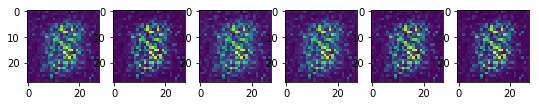

Epoch:0    Discriminator Loss:1.130095   Generator Loss:1.965640


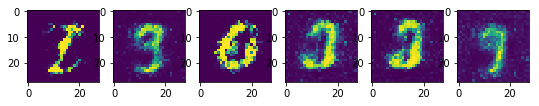

Epoch:5    Discriminator Loss:0.681637   Generator Loss:2.187040


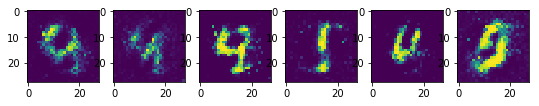

Epoch:10    Discriminator Loss:0.894522   Generator Loss:1.657669


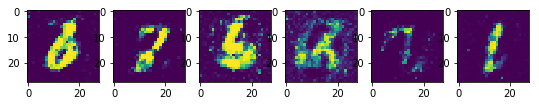

Epoch:15    Discriminator Loss:0.992944   Generator Loss:1.376445


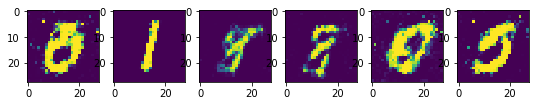

Epoch:20    Discriminator Loss:1.039809   Generator Loss:1.304945


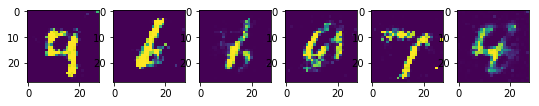

Epoch:25    Discriminator Loss:1.115377   Generator Loss:1.155181


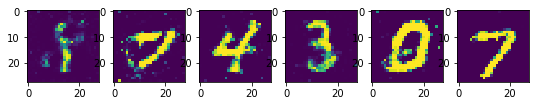

Epoch:30    Discriminator Loss:1.159926   Generator Loss:1.080716


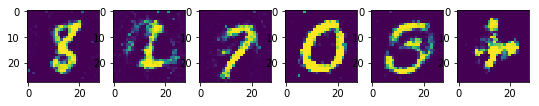

Epoch:35    Discriminator Loss:1.177214   Generator Loss:1.047474


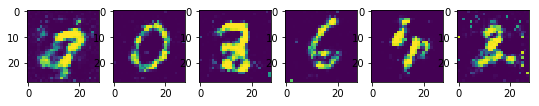

Epoch:40    Discriminator Loss:1.193131   Generator Loss:1.006436


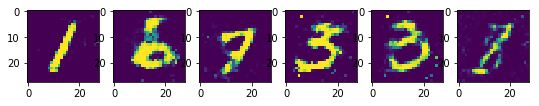

Epoch:45    Discriminator Loss:1.206479   Generator Loss:0.992957


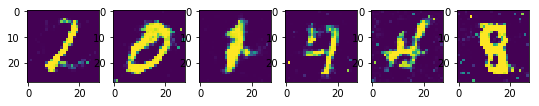

Epoch:50    Discriminator Loss:1.221567   Generator Loss:0.963970


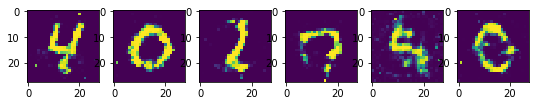

Epoch:55    Discriminator Loss:1.218793   Generator Loss:0.967074


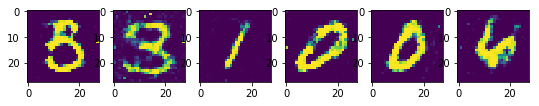

Epoch:60    Discriminator Loss:1.230514   Generator Loss:0.945203


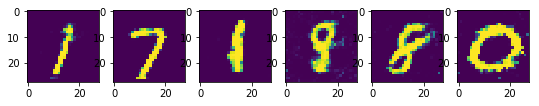

Epoch:65    Discriminator Loss:1.245890   Generator Loss:0.926462


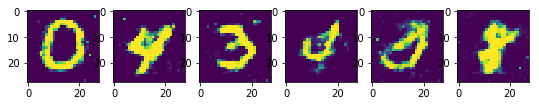

Epoch:70    Discriminator Loss:1.230909   Generator Loss:0.943099


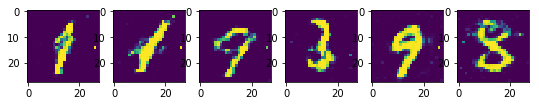

Epoch:75    Discriminator Loss:1.245913   Generator Loss:0.924272



In [12]:
steps=0
for epoch in tqdm(range(epochs)):
    dis_loss_val = 0
    gen_loss_val = 0
    for x,_ in train_loader:
        steps+=1
        dis_loss_val+=d_train(x)
        gen_loss_val+=g_train()
        
    dis_loss.append(dis_loss_val/len(train_loader))
    gen_loss.append(gen_loss_val/len(train_loader))
    
    if (epoch%5==0):
        # generate sample images from generator 
        fig = plt.figure(figsize=(9,1.5))
        generated_images = G(noise(6).cuda()).detach().cpu().numpy().reshape(6,28,28)*0.5 + 0.5
        for i in range(6):
            plt.subplot(1,6,i+1)
            plt.imshow(generated_images[i])
        plt.show()

        # log training statistics
        print("Epoch:{}    Discriminator Loss:{:.6f}   Generator Loss:{:.6f}".format(epoch, dis_loss[-1], 
                                                                             gen_loss[-1]))

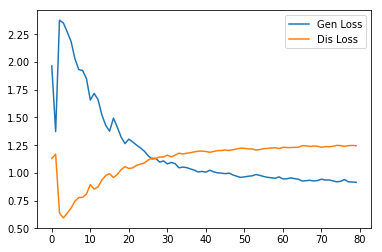

In [13]:
plt.plot(gen_loss, label="Gen Loss")
plt.plot(dis_loss, label="Dis Loss")
plt.legend()

#### Sample images from trained generator

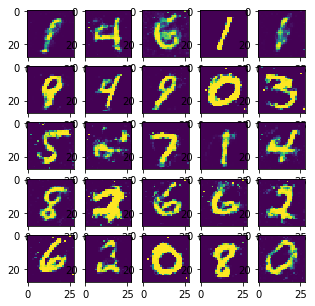

In [14]:
fig = plt.figure(figsize=(5,5))
generated_images = G(noise(25).cuda()).detach().cpu().numpy().reshape(25,28,28)*0.5 + 0.5
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(generated_images[i])
plt.show()

In [15]:
torch.save(G.state_dict(),"generator.pth")
torch.save(D.state_dict(),"discriminator.pth")

### Improving generation quality using discriminator

This is not a standard technique but a heuristic which I came up with. It might lead to reduction in variance of generated images.

Tested 567 images


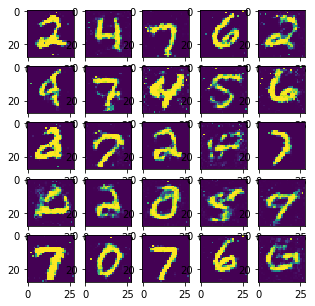

In [16]:
generated_images = []
counter = 0
with torch.no_grad():
    for i in range(25):
        pred = 0
        while pred<0.75:
            counter+=1
            img = G(noise(1).cuda())
            pred = D(img).cpu().item()
        generated_images.append(img.cpu().numpy().reshape(28,28)*0.5 + 0.5)

print("Tested {} images".format(counter))
fig = plt.figure(figsize=(5,5))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(generated_images[i])
plt.show()